In [28]:
import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import pandas as pd
import numpy as np
import datetime
import talib
from WindPy import *
w.start()
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [29]:
start_date = "2010-01-01"
end_date = "2021-07-19"
startdate = datetime.strptime(start_date, '%Y-%m-%d')
firstdate = datetime.strptime("2005-01-01", '%Y-%m-%d')
enddate = datetime.strptime(end_date, '%Y-%m-%d')
data = w.wsd("000300.SH", "high,low,close,open,volume",  firstdate, enddate, "Fill=Previous;PriceAdj=F")
data_df = pd.DataFrame(data.Data, index = ['最高价','最低价','收盘价','开盘价','成交量'], columns = data.Times).T
EquityIndex = w.wsd("000300.SH", "high,low,close,open,volume",  startdate, enddate, "Fill=Previous;PriceAdj=F")
EquityIndex_df = pd.DataFrame(EquityIndex.Data, index = ['最高价','最低价','收盘价','开盘价','成交量'], columns = EquityIndex.Times).T
lenth, lenth1 = len(EquityIndex_df), len(data_df)

In [30]:
######定义滤波函数######

def Hamilton(ts,h = 40,p = 4):
    # ts: the target time series, sort ascendingly in date.
    # h: forward periods.
    # p: lag periods.
    import statsmodels.api as sm
    regdata = pd.DataFrame()
    for i in range(0,p):
        regdata['lag'+str(i)] = ts.shift(i+h)
    regdata['forward'] = ts
    regdata = regdata.dropna(axis=0)
    col = regdata.columns.values.tolist()
    col.remove('forward')
    
    reg1 = sm.OLS(endog=regdata['forward'], exog=sm.add_constant(regdata[col])).fit()
    cyclical = reg1.resid
    
    dff = pd.Series([0]*(h+p-1))
    cyclical = pd.concat([dff,cyclical], axis=0 ,ignore_index=True)
    cyclical.index = ts.index
    
    return cyclical

In [31]:
######RSRS+成交量策略######
def RSRS_Vol(data_df,EquityIndex_df,N,M,K,T):    
    import statsmodels.api as sm
    high_list = data_df['最高价']
    low_list = data_df['最低价']
    df = data_df.copy()
    beta_list, rsquared_list, std_list, zscore_rightdev_list, zscore_std_list, v_signal_list = [0,0],[0,0],[0,0],[0,0],[0,0],[]

    for i in range(2,lenth1):
        if i < N + 1:
            beta_list.append(0)
            rsquared_list.append(0)
        else:
            y = df['最高价'].iloc[i-N:i+1]
            x = df['最低价'].iloc[i-N:i+1]
            X = sm.add_constant(x)
            model = sm.OLS(y,X)
            results = model.fit()
            beta_list.append(results.params.iloc[1])
            rsquared_list.append(results.rsquared)

    for j in range(2,lenth1):
        if j < M:
            zscore_std_list.append(0)  
            std_list.append(0)
        else:
            beta_list2 = beta_list.copy()
            mu = np.mean(beta_list2[j-M:j+1])
            sigma = np.std(beta_list2[j-M:j+1])
            zscore = (beta_list2[j]-mu)/sigma
            zscore_std= zscore*beta_list2[j]*rsquared_list[j]
            zscore_rightdev = zscore_std*beta_list[j]
            zscore_rightdev_list.append(zscore_rightdev)
            zscore_std_list.append(zscore_std)  
            std_list.append(zscore)
    
    import math
    vol_list = df['成交量']
    for k in range(lenth1):
        if k < K + 100:
            v_signal_list.append(0)
        else:
            vo_list = vol_list.copy()
            vo_list[k-K:k+1] = Hamilton(df['成交量'].iloc[k-K:k+1])
            v_today = vo_list[k]
            v_li = sorted(vo_list[k-K:k+1])
            v_rank = v_li.index(v_today)
            v_num = int(v_rank) / K
            if v_num ==1:
                v = 1
            else:
                v = math.floor(v_num * T) / (T - 1)
            v_signal_list.append(v)
            
    df['RSRS修正标准分'] = zscore_std_list
#    df['RSRS修正标准分'] = Hamilton(df['RSRS修正标准分'])
    
    EquityIndex_df['RSRS修正标准分'] = df['RSRS修正标准分'].iloc[lenth1-lenth:]
    EquityIndex_df['斜率'] = beta_list[lenth1-lenth:]
    EquityIndex_df['标准分'] = std_list[lenth1-lenth:]
    EquityIndex_df['成交量信号'] = v_signal_list[lenth1-lenth:]
    EquityIndex_df = EquityIndex_df.fillna(0)

    def cal_signal(EquityIndex_df):
        s = EquityIndex_df['RSRS修正标准分']
        if s > 0.7:
            signal = 1
        elif s < -0.7:
            signal = -1
        else:
            signal = 0
        return signal

    EquityIndex_df['signal'] = EquityIndex_df.apply(cal_signal, axis=1) 
    pos_list = [0]*lenth
    a = 0
    for i in range(0,lenth-1):
        a = pos_list[i] + EquityIndex_df['signal'][i]
        if a > -1 and a < 2:
            pos_list[i+1] = a
        else:
            pos_list[i+1] = pos_list[i]
            
    pos_list_revised = list(np.array(pos_list) * np.array(EquityIndex_df['成交量信号']))
    EquityIndex_df['position'] = pos_list
    EquityIndex_df['position_revised'] = pos_list_revised
    EquityIndex_df = pd.DataFrame(EquityIndex_df, index=EquityIndex_df.index)
    position_ser = EquityIndex_df['position'].copy()
    position_ser.iloc[0] = 0    
    position_ser.iloc[-1] = 0
    position_ser = position_ser.fillna(0)
    position_ser_revised = EquityIndex_df['position_revised'].copy()
    position_ser_revised.iloc[0] = 0    
    position_ser_revised.iloc[-1] = 0
    position_ser_revised = position_ser_revised.fillna(0)
    
    return position_ser, position_ser_revised

In [32]:
performance_df= pd.DataFrame(index = ['交易天数','区间收益','指数收益','区间年化','指数年化',\
                                   '持仓平均','日度胜率','最大回撤','回撤起始','回撤结束','交易次数','每年平均','夏普比率'])

def performance_summary(EquityIndex_df, position_ser_list, position_ser_revised_list, para_list, commission_list, \
                        trade_status = False, _print1 = False, _plot=True, _print=True):
    for i in range(len(commission_list)):
        position_ser = position_ser_list[i]
        position_ser_revised = position_ser_revised_list[i]
        para = para_list[i]
        commission = commission_list[i]
        EquityIndex_df['收益率'] = (((position_ser.shift(1)==position_ser)*EquityIndex_df['收盘价']/EquityIndex_df['收盘价'].shift(1)\
                                 + (position_ser.shift(1)!=position_ser)*EquityIndex_df['收盘价']/EquityIndex_df['开盘价'])\
                                 - len(EquityIndex_df['开盘价'])*[1])*position_ser_revised+len(EquityIndex_df['开盘价'])*[1]
        EquityIndex_df['手续费'] = list((position_ser.shift(1)!=position_ser)*abs(position_ser.shift(1)-position_ser)*commission)
        EquityIndex_df['除手续费收益率'] = EquityIndex_df['收益率'] - EquityIndex_df['手续费']

        # 取出pnl序列
        pnl_ser = EquityIndex_df['除手续费收益率']

        # 夏普比率
        up = (pnl_ser - [1] * len(pnl_ser)).mean()
        down = (pnl_ser - [1] * len(pnl_ser)).std()
        if down > 0:
            sharpe = up * 15.81 / down
        else:
            sharpe = 0

        # 天数
        trade_days = len(pnl_ser)

        # 收益
        EquityIndex_df['标准收盘价'] = list(np.array(EquityIndex_df['收盘价'])/EquityIndex_df['收盘价'][0])
        value_ser = pnl_ser.cumprod()
        total_yield = (value_ser[-1] - 1)
        compare_total_yield = (EquityIndex_df['标准收盘价'][-1] / EquityIndex_df['标准收盘价'][0] - 1)
        total_yield_per_year = np.sign(total_yield + 1) * (abs(total_yield + 1)) ** (250 / trade_days) - 1
        compare_total_yield_per_year = np.sign(compare_total_yield + 1) * (abs(compare_total_yield + 1)) ** (250 / trade_days) - 1
        
        #持仓单日收益
        num = np.count_nonzero(np.array(position_ser)!=0)
        avg_yield = total_yield / num

        # 最大回撤
        drawdown_ser = pd.Series(index=range(1, len(value_ser)+1), dtype='float64')
        for i in range(1, len(value_ser)):
            drawdown_ser[i] = value_ser[i] / value_ser[:i].max()
        max_drawdown = (1-drawdown_ser.min())

        # 最大回撤天数, 起止日期
        drawdown_index = np.argmin(drawdown_ser) + 1
        drawdown_date = value_ser.index[drawdown_index]
        max_index = np.argmax(value_ser[:drawdown_date])
        max_date = value_ser.index[max_index]

        # 交易次数
        trade_num = np.count_nonzero(np.array((position_ser - position_ser.shift(1))))
        num_per_year = trade_num *250 / trade_days

        # 胜率
        win_count = (pnl_ser > 1).sum()
        lose_count = (pnl_ser < 1).sum()
        win_rate = win_count / (win_count + lose_count)

        # 净值曲线
        if _plot:
            plt.figure(figsize=(22,4.3))
            plt.grid(linestyle='-.')
            plt.plot(value_ser, label = 'Strategy Return '+str(para))
            plt.scatter(max_date, value_ser[max_date], c='r')
            plt.scatter(drawdown_date, value_ser[drawdown_date], c='r')
            plt.fill_between(value_ser[max_date:drawdown_date].index,
                             value_ser.min(),
                             value_ser[max_date],
                             facecolor='green',
                             alpha=0.3)
            plt.plot(EquityIndex_df['标准收盘价'], color='black', label = 'Index Return')
            plt.legend(loc = 0, ncol = 2)


        performance_df[para]= [trade_days, total_yield, compare_total_yield, total_yield_per_year, compare_total_yield_per_year,\
                              avg_yield, win_rate, max_drawdown, max_date.strftime('%Y-%m-%d'), drawdown_date.strftime('%Y-%m-%d'),\
                              trade_num, num_per_year, sharpe]
        
        if _print1:
            print("-" * 30)
            print('交易天数：\t{}'.format(trade_days))
            print('区间收益：\t{:.2%}'.format(total_yield))
            print('指数收益：\t{:.2%}'.format(compare_total_yield))
            print('区间年化：\t{:.2%}'.format(total_yield_per_year))
            print('指数年化：\t{:.2%}'.format(compare_total_yield_per_year))
            print('日度胜率：\t{:.2%}'.format(win_rate))
            print("-" * 30)

            print("最大回撤：\t{:.2%}".format(max_drawdown))
            print("回撤起始：\t{}".format(max_date.strftime('%Y-%m-%d')))
            print("回撤结束：\t{}".format(drawdown_date.strftime('%Y-%m-%d')))
            print("-" * 30)

            print("交易次数：\t{}".format(trade_num))
            print("每年平均：\t{:.2f}".format(num_per_year))
            print("-" * 30)

            print('夏普比率：\t{:.2f}'.format(sharpe))
            print('持仓平均：\t{:.2%}'.format(avg_yield))
            print("-" * 30)

        if trade_status:
            bid_arr = EquityIndex_df['开盘价'].to_numpy()
            ask_arr = EquityIndex_df['开盘价'].to_numpy()

            temp = pd.DataFrame({'value':position_arr},index=EquityIndex_df.index)
            temp['value_shift'] = temp['value'].shift(1).fillna(0)

            change_pos = temp['value']-temp['value_shift']
            change_pos[0] = 0

            change_base = np.zeros(shape=len(EquityIndex_df))
            change_buy = change_pos > 0
            change_sell = change_pos < 0

            time_index = pd.Series(EquityIndex_df.index,index = EquityIndex_df.index)

            buy_time = EquityIndex_df.loc[change_buy].index.tolist()
            buy_index = [time_index[x] for x in buy_time]
            buy_price = EquityIndex_df.loc[change_buy]['开盘价'].tolist()

            sell_time = EquityIndex_df.loc[change_sell].index.tolist()
            sell_index = [time_index[x] for x in sell_time]
            sell_price = EquityIndex_df.loc[change_sell]['开盘价'].tolist()

            change_base[change_buy] = ask_arr[change_buy]
            change_base[change_sell] = bid_arr[change_sell]

            plt.figure(figsize=(22, 5))
            plt.plot(EquityIndex_df['收盘价'], color='black')
            plt.scatter(buy_index,
                buy_price,
                marker='^',
                color='red',
                zorder=100,
                s=70)
            plt.scatter(sell_index,
                sell_price,
                marker='v',
                color='green',
                zorder=100,
                s=70)
            
    performance_df.iloc[1:8,:] = performance_df.iloc[1:8,:].applymap(lambda x: '%.2f%%' % (x*100))
    if _print:        
        return performance_df.T

,交易天数,区间收益,指数收益,区间年化,指数年化,持仓平均,日度胜率,最大回撤,回撤起始,回撤结束,交易次数,每年平均,夏普比率
N=17 M=550 K=400 T=4,2805,796.84%,44.64%,21.59%,3.34%,0.53%,54.08%,14.47%,2021-02-10,2021-03-25,79,7.040998,1.62037


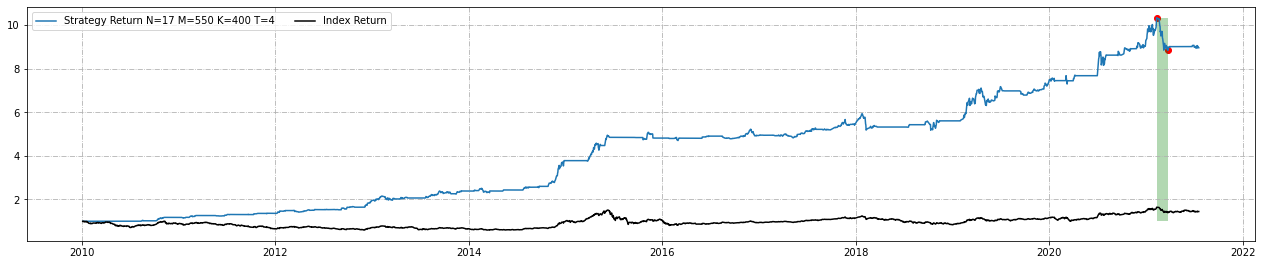

In [33]:
position_ser_list = [RSRS_Vol(data_df,EquityIndex_df,N=17,M=550,K=400,T=4)[0]]
position_ser_revised_list = [RSRS_Vol(data_df,EquityIndex_df,N=17,M=550,K=400,T=4)[1]]
commission_list = [0.001]
para_list = ['N=17 M=550 K=400 T=4']

performance_summary(EquityIndex_df, position_ser_list, position_ser_revised_list, para_list, commission_list)